# Med Phys/ BME 573 - Lecture 32: Noise propagation in quantitative imaging

## Example signal model (MRI R2* relaxometry)

$s(TE) = A e^{-  TE \, R_2^* }$

**Known parameters**: TE values (say, 6 echo times)


**Unknown parameters**: $A, R_2^*$




In [1]:
## MP 573: Monte-Carlo simulation: quantitative MRI noise propagation
##
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
import matplotlib.image as mpimg
from os.path import dirname, join as pjoin
import scipy.io as sio
from dataclasses import dataclass
from scipy.optimize import curve_fit
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
@dataclass
class trueParams: # Tissue parameters to simulate multi-echo MRI signal
    A: float
    phi: float
    r2star: float
    fieldmap: float = 0.0
        
@dataclass
class imDataParams: # Acquisition parameters to simulate multi-echo signal
    FieldStrength: float
    TE: list
        
# This function synthetizes some multi-echo signal given tissue and acquisition parameters       
def create_signal(imP, trueP):
    s = trueP.A*np.exp(1j*trueP.phi)*np.exp(-imP.TE*trueP.r2star + 1j*trueP.phi + 1j*2*np.pi*imP.TE*trueP.fieldmap)
    
    return s

# Wrapper for create_signal function above     
def create_signal_r2star(TE, A,r2star):
    
    global myImDataParams
    
    fieldmap = 0
    phi = 0
    myTrueParams = trueParams(A, phi, r2star,fieldmap)

    s = create_signal(myImDataParams, myTrueParams)
    
    s2 = np.abs(s)
       
    return s2


# Make the fonts large
font = {'weight' : 'normal',
        'size'   : 16}

global myImDataParams
global t
global s1

## Visualize the distribution of noisy signals at the input and output

We will generate an underlying noiseless multi-echo signal with various different parameters. From this noiseles multi-echo signal, we will generate many noisy realizations of the signal (ie: signal plus noise). Each noisy realization of the signal mimics the signal observed at a single pixel across echo times. For each pixel, we will perform non-linear least squares fitting to estimate $R_2^*$. Finally, we will plot the distribution of measured $R_2^*$ across our realizations (ie: across our pixels).

In [3]:
import scipy.stats as stats

# Plot the least-squares signal fit given some echo time combination
def showFitNoise(R2star,TE1,dTE, SNR):
    global myImDataParams
    global t
    global s1
    global axs, fig
    
    font = {'weight' : 'normal',
        'size'   : 16}
        
    # Set the true  R2* from function input
    true_R2star = R2star
    myTrueParams = trueParams(100., 0., true_R2star, 0.)

    # Generate continuous-looking noiseless true signal
    N = 1001
    tmax = 20*0.001
    t = np.linspace(0.0,tmax,N)
    myImDataParams = imDataParams(1.5, t)
    s1 = create_signal(myImDataParams, myTrueParams );


    # Generate the echo time combination given TE1 and dTE
    TE1 = TE1*0.001
    dTE = dTE*0.001
    nTE = 6
    TE = np.linspace(TE1,TE1 + (nTE-1)*dTE,nTE)
    myImDataParams = imDataParams(1.5, TE)

    # Create noiseless signal
    s = create_signal(myImDataParams, myTrueParams);


    # Calculate noise standard deviation
    sigma = 100/SNR;

    

    # Generate multiple noisy realizations and estimate R2* from each
    Npixels = 100;
    r2est = np.zeros(Npixels)    
    sfit3 = np.zeros((N, Npixels))
    snall = np.zeros((nTE, Npixels))
    for k in range(Npixels):
        sn = s +  stats.norm.rvs(0, sigma, size=(nTE)) + stats.norm.rvs(0, sigma, size=(nTE))*1j
        snall[:,k] = np.abs(sn) 
        p0 = np.array([90.,40.])
        popt, pcov = curve_fit(create_signal_r2star, TE, abs(sn), p0);
        sfit = create_signal_r2star( TE, popt[0], popt[1])
        
        myEstParams = trueParams(popt[0], 0., popt[1], 0.)
        mySimParams = imDataParams(1.5, t)
        sfit3[:,k] = np.abs(create_signal(mySimParams, myEstParams));
        r2est[k] = popt[1]
        
    print('\nR2 estimate mean:' + '{:.1f}'.format(np.mean(r2est)) + ', std: ' + '{:.1f}'.format(np.sqrt(np.var(r2est))))
    


    # Display results
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(15, 7)
    fig.subplots_adjust(hspace=0.3,wspace=0.3)
    axs[0].plot(t*1000,abs(sfit3),'g',linewidth=1.0);
    axs[0].plot(t*1000,abs(s1),'gray',linewidth=6.0);
    axs[0].plot(TE*1000,abs(s),'or',markersize=12);
    axs[0].plot(TE*1000,abs(snall),'oc',markersize=6);
    axs[0].set_xlabel('Echo Time (ms)');
    axs[0].set_ylabel('Signal (AU)');
    axs[0].set_title('Measured and estimated signals' );

    
    axs[1].boxplot(r2est);
    axs[1].set_ylim([0, 500])
    axs[1].set_ylabel('R2* estimates');
    axs[1].set_title('True R2*=' + '{:.1f}'.format(true_R2star)  +  ', Est R2*=' + '{:.1f}'.format(np.mean(r2est)) + '$\pm$' + '{:.1f}'.format(np.sqrt(np.var(r2est)))  );
    axs[1].set_xticks([])
    plt.show()
    plt.rc('font', **font)



In [4]:
## Create interactive slide bar
global axs, fig
y = interactive(showFitNoise,R2star=(20,500,10),TE1=(0.4,3.0,0.05),dTE=(0.6,4.0,0.05), SNR=(5,40,5))
display(y)

interactive(children=(IntSlider(value=260, description='R2star', max=500, min=20, step=10), FloatSlider(value=…

## Visualize the R2* noise across echo time combinations

In this next cell we will fix most parameters (true R2*, number of echoes, SNR) and will evaluate the bias and standard deviation in measured R2* for different echo time combinations. These echo time combinations are determined by the initial echo time ($TE_1$) and the echo time spacing ($\Delta TE$). This approach allows us to optimize the choice of echo times for R2* estimation with low bias and low standard deviation. 

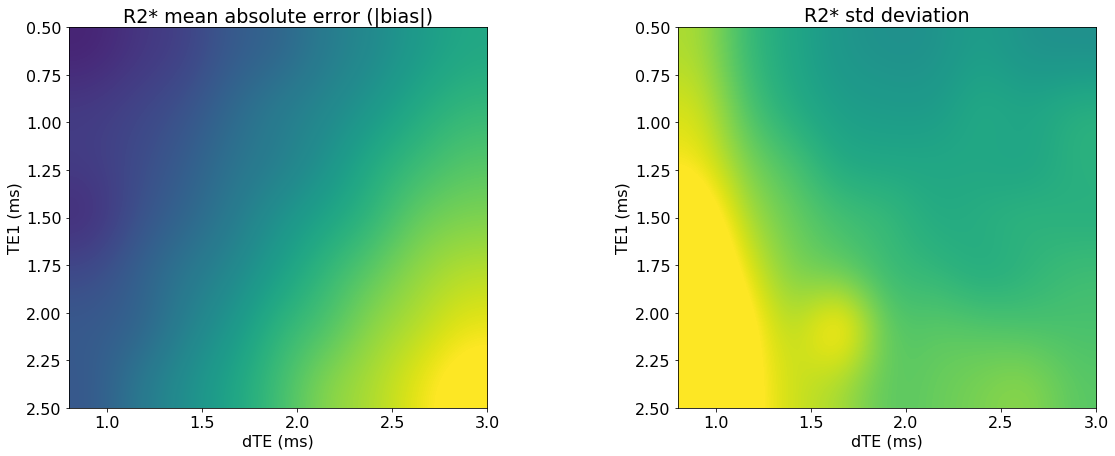

In [5]:
import scipy.stats as stats

# Create noise propagation plot
global myImDataParams
global t
global s1   
    
nTE1 = 7;
ndTE = 9;
TE1s = np.linspace(0.5,2.5,nTE1)
dTEs = np.linspace(0.8,3.0,ndTE)

r2means = np.zeros((nTE1,ndTE))
r2stds = np.zeros((nTE1,ndTE))


# For each TE combination (choice of TE1 and dTE), generate signal, 
# add noise multiple times to obtain multiple noisy signal realizations, 
# and estimate R2* from each noisy signal realization 
for k1 in range(np.size(TE1s)):
    for k2 in range(np.size(dTEs)):
        
        TE1 = TE1s[k1]*0.001
        dTE = dTEs[k2]*0.001
        nTE = 6
        TE = np.linspace(TE1,TE1 + (nTE-1)*dTE,nTE)
        myImDataParams = imDataParams(1.5, TE)
        
        # Set some true  R2* 
        true_R2star = 200
        myTrueParams = trueParams(100., 0., true_R2star, 0.)
        
        s = create_signal(myImDataParams, myTrueParams );
    
        sigma = 15;
        Npixels = 2000;
    
        r2est = np.zeros(Npixels)
    
        for k in range(Npixels):
            sn = s +  stats.norm.rvs(0, sigma, size=(nTE)) + stats.norm.rvs(0, sigma, size=(nTE))*1j
    
            p0 = np.array([90.,40.])
            try:
                popt, pcov = curve_fit(create_signal_r2star, TE, abs(sn), p0);
            except RuntimeError:
                popt = p0
            sfit = create_signal_r2star( TE, popt[0], popt[1])
            r2est[k] = popt[1]

        r2means[k1,k2] = np.mean(r2est)
        r2stds[k1,k2] = np.sqrt(np.var(r2est))

# Display the bias and the standard deviation in R2* estimates 
# as a function of TE combination             
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.imshow(np.abs(r2means-true_R2star),interpolation='bicubic', extent = [dTEs[0], dTEs[-1], TE1s[-1], TE1s[0] ], vmin=0, vmax=80);
plt.xlabel('dTE (ms)');
plt.ylabel('TE1 (ms)');
plt.title('R2* mean absolute error (|bias|)' );
plt.rc('font', **font)
plt.subplot(1,2,2)
plt.imshow(r2stds,interpolation='bicubic',extent = [dTEs[0], dTEs[-1], TE1s[-1], TE1s[0] ], vmin=20, vmax=80);
plt.xlabel('dTE (ms)');
plt.ylabel('TE1 (ms)');
plt.title('R2* std deviation' );
plt.rc('font', **font)

